# 从零开始构建一个大模型（仅encoder版）

大模型可以大概分为以下几个部分



## 归一化方式

使用RMSNorm替代了原来的层归一化（层间归一化每次都需要计算方差和均值）。RMSNorm仅用计算均方根，简化了计算的同时，还有可能带来性能上的提升

### 层归一化公式

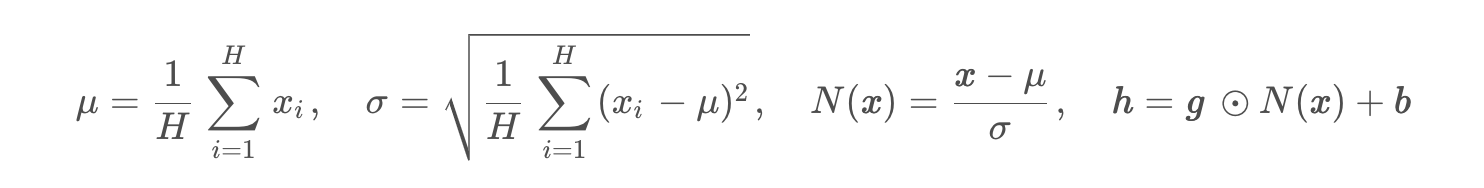

### RMSNorm归一化公式

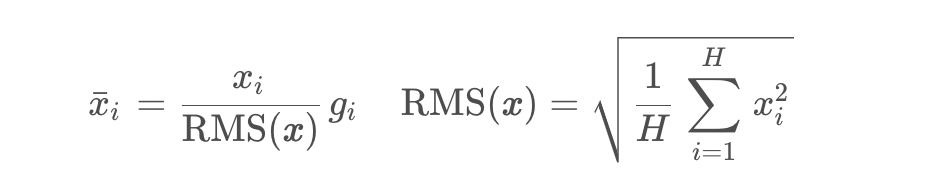

### 使用归一化的好处

* 减少内部协变量偏移（Internal Covariate Shift）： 内部协变量偏移是指在深度神经网络的训练过程中，每一层输入的分布会发生变化，导致网络的训练变得困难。层归一化通过对每一层的输入进行归一化处理，可以减少内部协变量偏移，使得每一层的输入分布更加稳定。
* 稳定化梯度： 层归一化有助于保持每一层输出的均值和方差稳定，从而使得梯度的传播更加稳定。这有助于减少梯度消失或梯度爆炸的问题，提高梯度在网络中的流动性，加快训练速度。
* 更好的参数初始化和学习率调整： 通过层归一化，每一层的输入分布被归一化到均值为0、方差为1的标准正态分布，这有助于更好地初始化网络参数和调整学习率。参数初始化与学习率调整的稳定性对模型的训练效果至关重要。
* 增强模型的泛化能力： 层归一化可以减少网络对训练数据分布的依赖，降低了过拟合的风险，从而提高模型的泛化能力。稳定的输入分布有助于模型更好地适应不同数据集和任务。

In [1]:
import torch
import torch.nn as nn

class RMSNorm(nn.Module):
  def __init__(self, dim: int, eps: float = 1e-6):
    super().__init__()
    self.eps = eps
    self.weight = nn.Parameter(torch.ones(dim))
  
  def _norm(self, x):
    variance = x.pow(2).mean(-1, keepdim=True)
    return x * torch.rsqrt(variance + self.eps)
  
  def forward(self, x):
    return self.weight * self._norm(x.float()).type_as(x)

In [3]:
import torch
import torch.nn as nn
from torch import Tensor

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear = nn.Linear(in_features=10, out_features=5)
        self.rmsnorm = RMSNorm(dim=5)

    def forward(self, x):
        x = self.linear(x)
        x = self.rmsnorm(x)
        return x


net = SimpleNet()


input_data = torch.randn(2, 10)  # 2个样本，每个样本包含10个特征

output = net(input_data)

print("Input Shape:", input_data.shape)
print("Output Shape:", output.shape)


Input Shape: torch.Size([2, 10])
Output Shape: torch.Size([2, 5])


## 位置编码

引入位置编码的目的是让transformer结构知道不同的token所在的位置，以及他们之间的相对位置关系

### 标准位置编码

标准位置编码的想法很简单，直接在token的embedding基础上使用sin和cos加入了位置信息

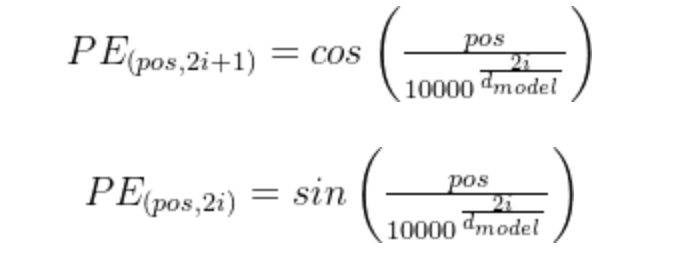

其中pos代表的是token的位置，所以每个token都是一致的，然后i的长短是要根据embedding的长度来确定的。

### 旋转位置编码
RoPE 通过将位置编码以旋转矩阵的形式嵌入到查询（Query）和键（Key）向量中，使得模型能够有效捕捉序列中不同位置之间的相对关系。


#### RoPE 的原理
- **旋转矩阵**：RoPE 利用二维旋转矩阵，将位置编码以旋转的形式应用于向量的每一对子维度。
- **多尺度表示**: 不同频率的旋转使得 RoPE 能在多个尺度上捕捉位置差异，类似于傅里叶变换中的多频率表示。
- **远端衰减效应**：随着位置差异 \( |q - p| \) 的增加，不同频率的相位差叠加导致内积结果逐渐衰减，使得模型更关注局部相关性。

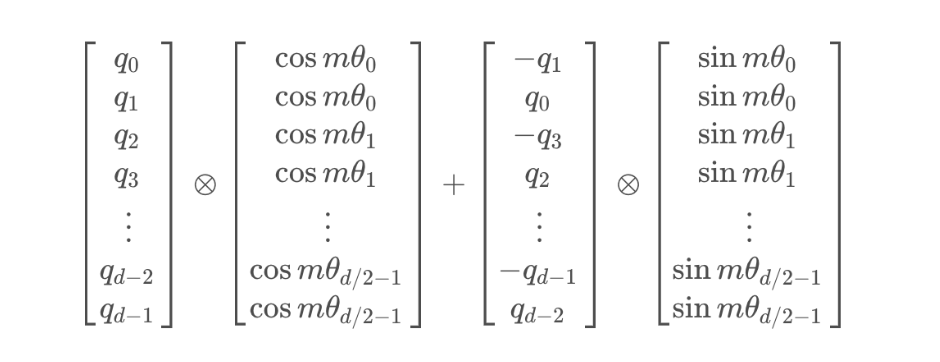

In [3]:
import torch

def sinusoidal_position_embedding(batch_size, nums_head, max_len, output_dim, device):
    # (max_len, 1)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(-1)
 
    # (output_dim//2)
    # 即公式里的i, i的范围是 [0,d/2]
    ids = torch.arange(0, output_dim // 2, dtype=torch.float)  
    theta = torch.pow(10000, -2 * ids / output_dim)
 
    # (max_len, output_dim//2)
    # 即公式里的：pos / (10000^(2i/d))
    embeddings = position * theta 
 
    # (max_len, output_dim//2, 2)
    embeddings = torch.stack([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
 
    # (bs, head, max_len, output_dim//2, 2)
    # 在bs维度重复，其他维度都是1不重复
    embeddings = embeddings.repeat((batch_size, nums_head, *([1] * len(embeddings.shape))))  
 
    # (bs, head, max_len, output_dim)
    # reshape后就是：偶数sin, 奇数cos了
    embeddings = torch.reshape(embeddings, (batch_size, nums_head, max_len, output_dim))
    embeddings = embeddings.to(device)
    return embeddings

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
 
 
def RoPE(q, k):
    # q,k: (bs, head, max_len, output_dim)
    batch_size = q.shape[0]
    nums_head = q.shape[1]
    max_len = q.shape[2]
    output_dim = q.shape[-1]
 
    # (bs, head, max_len, output_dim)
    pos_emb = sinusoidal_position_embedding(batch_size, nums_head, max_len, output_dim, q.device)
 
 
    # cos_pos,sin_pos: (bs, head, max_len, output_dim)
    # 看rope公式可知，相邻cos，sin之间是相同的，所以复制一遍。如(1,2,3)变成(1,1,2,2,3,3)
    cos_pos = pos_emb[...,  1::2].repeat_interleave(2, dim=-1)  # 将奇数列信息抽取出来也就是cos 拿出来并复制
    sin_pos = pos_emb[..., ::2].repeat_interleave(2, dim=-1)  # 将偶数列信息抽取出来也就是sin 拿出来并复制
 
    # q,k: (bs, head, max_len, output_dim)
    q2 = torch.stack([-q[..., 1::2], q[..., ::2]], dim=-1)
    q2 = q2.reshape(q.shape)  # reshape后就是正负交替了
 
    # 更新qw, *对应位置相乘
    q = q * cos_pos + q2 * sin_pos
 
    k2 = torch.stack([-k[..., 1::2], k[..., ::2]], dim=-1)
    k2 = k2.reshape(k.shape)
    # 更新kw, *对应位置相乘
    k = k * cos_pos + k2 * sin_pos
 
    return q, k

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super(MultiHeadAttention, self).__init__()

        self.h = heads
        # 每个头的维度
        self.d_k = d_model // heads
        self.d_model = d_model

        self.k_linear = nn.Linear(d_model, d_model)
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

        self.k_cache, self.v_cache = None, None  # 初始化 KV 缓存
    
    def attention(self, q, k, v, d_k, mask=None):
        scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)

        if mask is not None:
            # mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9) #序列中的填充项不应该对注意力计算产生影响。通过将这些位置的分数设置为负无穷大，可以确保这些填充项在计算softmax时被忽略。
            #print(scores.data)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout(scores)

        output = torch.matmul(scores, v)

        return output
    
    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        q, k = RoPE(q, k)

        q = torch.transpose(q, 1, 2)
        k = torch.transpose(k, 1, 2)
        v = torch.transpose(v, 1, 2)

        scores = self.attention(q, k, v, self.d_k, mask)

        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)

        return output